In [1]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
#from scipy.spatial import distance_matrix
from colour import Color
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from collections import Counter


#Some global parameters:
#Minimum number of tornados in each cluster

numt=2

#Radius of the tornadoes for F1 and higher and for F2 and higher (in km):
radF1=40


F1_plus={'EF1','EF2','EF3','EF4','EF5','F1','F2','F3','F4','F5'}


In [2]:
F1_plus={'EF1','EF2','EF3','EF4','EF5','F1','F2','F3','F4','F5'}
F2_plus=F1_plus-{"EF1",'F1'}
F3_plus=F2_plus-{'EF2','F2'}
F4_plus=F3_plus-{'EF3','F3'}
F5=F4_plus-{'EF4','F4'}

In [3]:
# Import the data
data_file= pd.read_csv('StormEvents_details_WORKING.csv')




In [4]:
#Define a function that takes a tornado data , sort them by the date, checks if the torandoes appear in the prescribed radius and are of the same type
# and returns only those that form a  cluster 

def clust(data,type,radius):
    #Create outcome Dataframe 
    clusters=pd.DataFrame()
    
    # First sort  by the same date and delete those groups that have < numt torandoes 

    gr=data.groupby(["BEGIN_YEARMONTH","BEGIN_DAY"]).groups
    for k,v in gr.copy():
       if len(gr[k,v]) <numt:
          del gr[k,v]


    for y,d in gr:
# Form a group of the tornadoes that happen in the same day 
        mini=data.loc[gr[y,d]]
            
    
    # Introduce the adjacency matrix and  some distances 
    
        
        adj=np.zeros((len(mini),len(mini)))
        dist1=np.zeros((len(mini),len(mini)))
        ind=[]
        for  i in range(len(mini)):
          for k in range(i+1,len(mini)):
    # converting lat and lon distnces in km 
               lat1=radians(mini['BEGIN_LAT'].iloc[i])
               lat2=radians(mini['BEGIN_LAT'].iloc[k])
               dlat=lat1-lat2
               dlon=radians(mini['BEGIN_LON'].iloc[i]-mini['BEGIN_LON'].iloc[k])
                
    # calculating distnce using  lat, lon and converting to  km
    # https://www.geeksforgeeks.org/program-distance-two-points-earth/
            
               distance = 2*6367*asin(sqrt(sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2))//1
              
    
    #form a matrix of 0 and 1 with rows and columns are tornadoes from the group
    #with i,j entry = 1   if torando i and tornado j happen within the prescribed radius  and if they are in F1_plus group  :
               if  (distance< radius) and (mini['TOR_F_SCALE'].iloc[i] in type) and (mini['TOR_F_SCALE'].iloc[k] in type)  :
                 adj[i,k]=1
    
        
    # find the conneced components of the graph with adjacency matrix = adj    =    finding which tornadoes form a cluster  
        con_comp=connected_components(adj)
        
    
        
    #create a "cluster" group column 
        mini['cluster'] = np.nan
        for a,b in enumerate(con_comp[1]):
            mini.iloc[a,-1]=b*0.00001 # mini['BEGIN_EARMONTH'].iloc[a]*100+b*0.0001
        
    
# consider only clusters that  have more then numt tornadoes inside 
        new_cluster=mini[mini.groupby('cluster')['cluster'].transform('size') >= numt]
        new_cluster.iloc[:,-1]=new_cluster.iloc[:,-1] +y*100+d
 
        clusters = pd.concat([clusters, new_cluster], ignore_index = False)


    return clusters

In [253]:
Clust_F1=clust(data_file,F1_plus,radF1)
data_file['casualties']=data_file['INJURIES_DIRECT']+data_file['INJURIES_INDIRECT']+data_file['DEATHS_DIRECT']+data_file['DEATHS_INDIRECT']
Clust_F1['casualties']=Clust_F1['INJURIES_DIRECT']+Clust_F1['INJURIES_INDIRECT']+Clust_F1['DEATHS_DIRECT']+Clust_F1['DEATHS_INDIRECT']

In [6]:
Clust_F1.head()

,Unnamed: 0,BEGIN_YEARMONTH,BEGIN_DAY,END_YEARMONTH,END_DAY,EVENT_ID,STATE,STATE_FIPS,EVENT_TYPE,CZ_TYPE,...,DEATHS_INDIRECT,DAMAGE_PROPERTY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,cluster
52,52,195001,3,195001,3,10063615,MISSOURI,29.0,Tornado,C,...,0,2.5M,F3,6.2,150.0,38.77,-90.22,NaN,NaN,1.950010e+07
186,186,195001,3,195001,3,10009710,ILLINOIS,17.0,Tornado,C,...,0,250K,F3,3.3,100.0,38.82,-90.10,NaN,NaN,1.950010e+07
32,32,195002,11,195002,11,10120403,TEXAS,48.0,Tornado,C,...,0,25K,F3,12.0,1000.0,29.67,-95.05,NaN,NaN,1.950021e+07
151,151,195002,11,195002,11,10120402,TEXAS,48.0,Tornado,C,...,0,25K,F2,9.9,400.0,29.42,-95.25,NaN,NaN,1.950021e+07
38,38,195002,12,195002,12,10120409,TEXAS,48.0,Tornado,C,...,0,250K,F1,7.7,100.0,31.80,-94.20,NaN,NaN,1.950021e+07


# <center>BY YEARS</center>

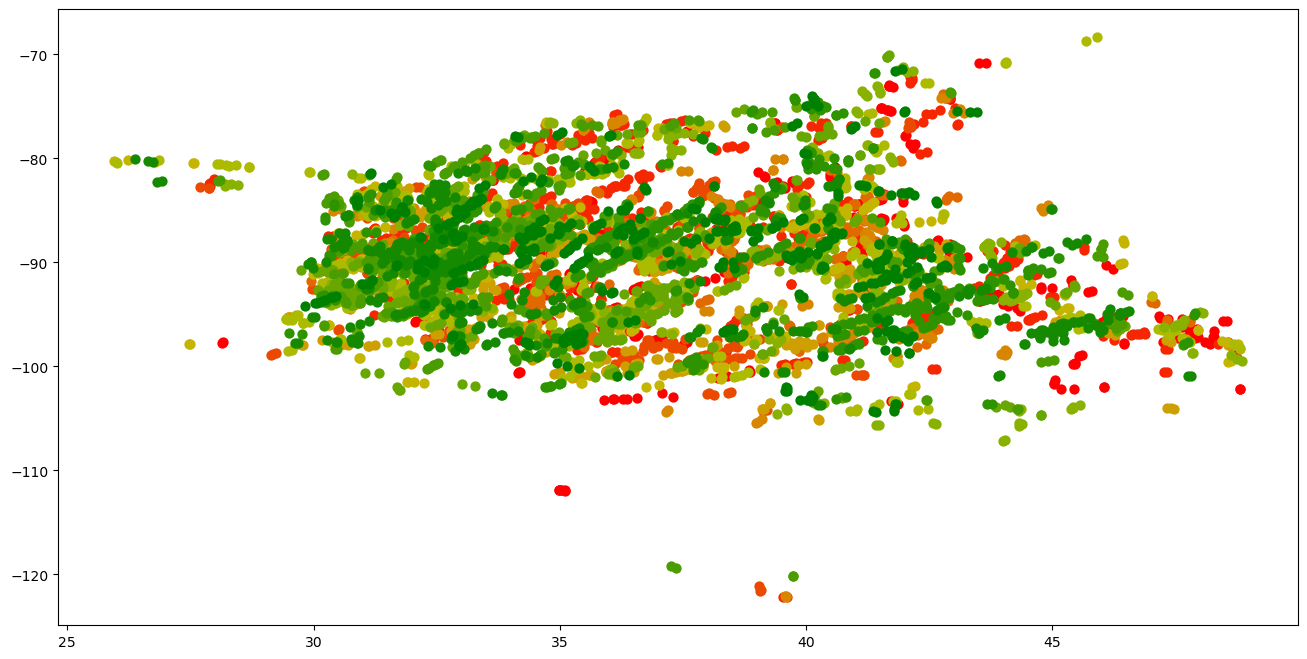

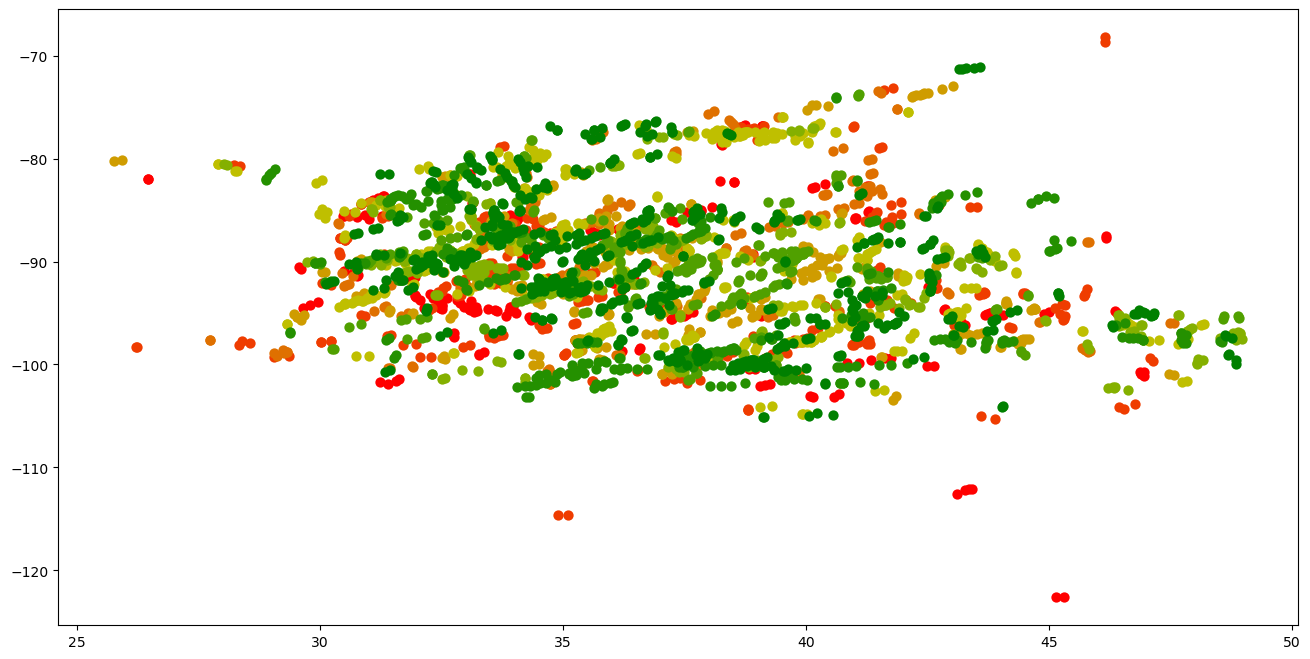

In [7]:
red = Color("red")
years=np.arange(2010,2024,1)
colors = list(red.range_to(Color("green"),len(years)))




plt.figure(figsize=[16,8])   
for  n,y in enumerate(years):

    plt.scatter(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LAT'] ,
                   Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LON'] ,
                    c = str(colors[n]), 
                    s= 55, 
                    linewidth = 0) 
 
 
    
plt.show()

years=np.arange(2000,2009,1)
colors = list(red.range_to(Color("green"),len(years)))




plt.figure(figsize=[16,8])   
for  n,y in enumerate(years):

    plt.scatter(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LAT'] ,
                   Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LON'] ,
                    c = str(colors[n]), 
                    s= 55, 
                    linewidth = 0) 
     
 

plt.show()

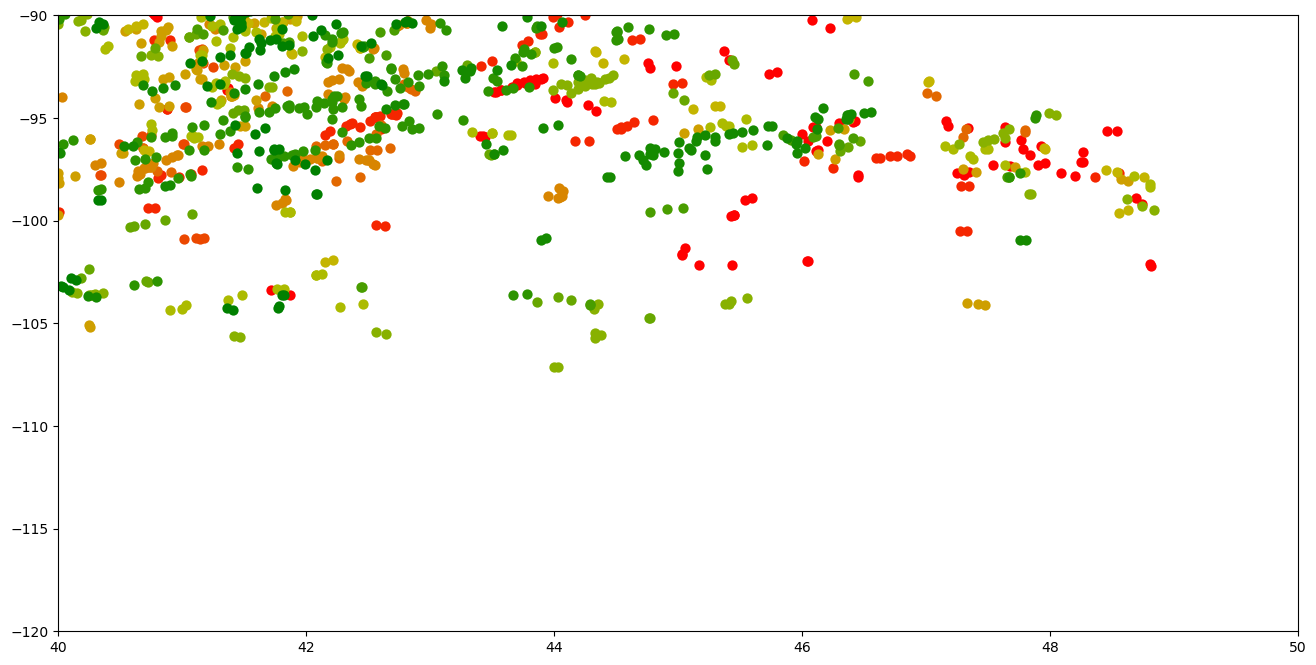

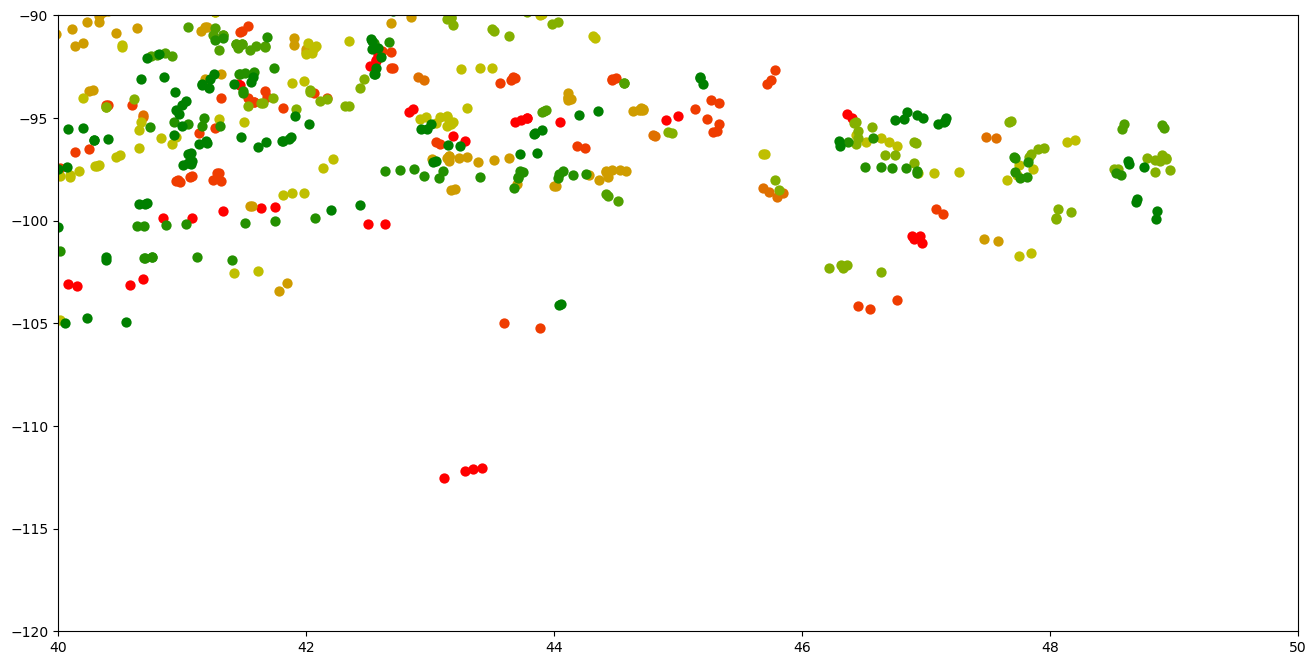

In [8]:
# Some graphs, green is newer, red is older 
# just decided to comsider   Lat in (40, 50) Lon in (-120, -90) as a "SE sector"


from colour import Color
red = Color("red")
years=np.arange(2010,2024,1)
colors = list(red.range_to(Color("green"),len(years)))




plt.figure(figsize=[16,8])   
for  n,y in enumerate(years):

    plt.scatter(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LAT'] ,
                   Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LON'] ,
                    c = str(colors[n]), 
                    s= 55, 
                    linewidth = 0) 
 
 
    plt.xlim(40, 50)
    plt.ylim(-120, -90)
plt.show()

years=np.arange(2000,2009,1)
colors = list(red.range_to(Color("green"),len(years)))




plt.figure(figsize=[16,8])   
for  n,y in enumerate(years):

    plt.scatter(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LAT'] ,
                   Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100==y,'BEGIN_LON'] ,
                    c = str(colors[n]), 
                    s= 55, 
                    linewidth = 0) 
    plt.xlim(40, 50)
    plt.ylim(-120, -90)
 

plt.show()

In [97]:
# some statistics 


def mean_LatLon(cluster,year_beg,year_end):
    df=pd.DataFrame(columns = ['Year','Mean_LAT', 'Mean_LON','Tot_tornadoes', 'Num_SE', 'Ratio'])
    for  y in range(year_beg,year_end+1):  
       Num_Tot=len(cluster.loc[cluster['cluster']//10000  ==y ])
       Mean_LAT= cluster.loc[cluster['cluster']//10000  ==y ,'BEGIN_LAT'].mean()
       Mean_LON=cluster.loc[cluster['cluster']//10000  ==y ,'BEGIN_LON'].mean()
       Num_WE=len(cluster.loc[(cluster['cluster']//10000  ==y ) & (cluster['BEGIN_LAT']>40 ) &(cluster['BEGIN_LON']<-90)] )
       ratio=Num_WE/Num_Tot

       
       df.loc[-1] = [y, Mean_LAT, Mean_LON,Num_Tot,Num_WE,ratio]
       df.index=df.index+1
    return  df.sort_values(by=['Year'])

In [11]:
'''def mean_LatLon(clust,year_beg,year_end):
    mean_LatLon=pd.DataFrame(columns = ['Year','Mean_LAT', 'Mean_LON','Num_Tot', 'Num_SE', 'Ratio','Num_F2plus'])
    for  y in range(year_beg,year_end+1):  
       Num=len(clust.loc[clust['cluster']//10000  ==y ])
       Mean_LAT= clust.loc[clust['cluster']//10000  ==y ][['BEGIN_LAT','BEGIN_LON']].mean().iloc[0] 
       Mean_LON=clust.loc[clust['cluster']//10000  ==y ][['BEGIN_LAT','BEGIN_LON']].mean().iloc[1]
       Num_WE=len(clust.loc[(clust['cluster']//10000  ==y ) & (clust['BEGIN_LAT']>40 ) &(clust['BEGIN_LON']<-90)] )
       ratio=Num_WE/Num
       Num_F2plus = len(Clust_F1[Clust_F1['TOR_F_SCALE'].isin(F2_plus)][clust['cluster']//10000  ==y ])

        
       mean_LatLon = pd.concat([pd.DataFrame([[y, Mean_LAT, Mean_LON,Num,Num_WE,ratio,Num_F2plus]], columns= mean_LatLon.columns),  mean_LatLon], ignore_index=True)
    return  mean_LatLon'''

"def mean_LatLon(clust,year_beg,year_end):\n    mean_LatLon=pd.DataFrame(columns = ['Year','Mean_LAT', 'Mean_LON','Num_Tot', 'Num_SE', 'Ratio','Num_F2plus'])\n    for  y in range(year_beg,year_end+1):  \n       Num=len(clust.loc[clust['cluster']//10000  ==y ])\n       Mean_LAT= clust.loc[clust['cluster']//10000  ==y ][['BEGIN_LAT','BEGIN_LON']].mean().iloc[0] \n       Mean_LON=clust.loc[clust['cluster']//10000  ==y ][['BEGIN_LAT','BEGIN_LON']].mean().iloc[1]\n       Num_WE=len(clust.loc[(clust['cluster']//10000  ==y ) & (clust['BEGIN_LAT']>40 ) &(clust['BEGIN_LON']<-90)] )\n       ratio=Num_WE/Num\n       Num_F2plus = len(Clust_F1[Clust_F1['TOR_F_SCALE'].isin(F2_plus)][clust['cluster']//10000  ==y ])\n\n        \n       mean_LatLon = pd.concat([pd.DataFrame([[y, Mean_LAT, Mean_LON,Num,Num_WE,ratio,Num_F2plus]], columns= mean_LatLon.columns),  mean_LatLon], ignore_index=True)\n    return  mean_LatLon"

In [98]:
MeanF1=mean_LatLon(Clust_F1,2000,2023)

In [99]:
MeanF1

,Year,Mean_LAT,Mean_LON,Tot_tornadoes,Num_SE,Ratio
23,2000.0,36.482037,-91.871142,216.0,40.0,0.185185
22,2001.0,36.889206,-92.417810,277.0,61.0,0.220217
21,2002.0,36.795759,-89.239360,224.0,12.0,0.053571
20,2003.0,37.311838,-90.990667,350.0,62.0,0.177143
19,2004.0,37.366848,-89.096008,405.0,69.0,0.170370
18,2005.0,37.597729,-91.548136,295.0,65.0,0.220339
17,2006.0,37.284163,-90.272363,285.0,31.0,0.108772
16,2007.0,37.459770,-93.107758,334.0,65.0,0.194611
15,2008.0,36.947684,-90.378561,619.0,100.0,0.161551
14,2009.0,35.400150,-90.131327,327.0,24.0,0.073394


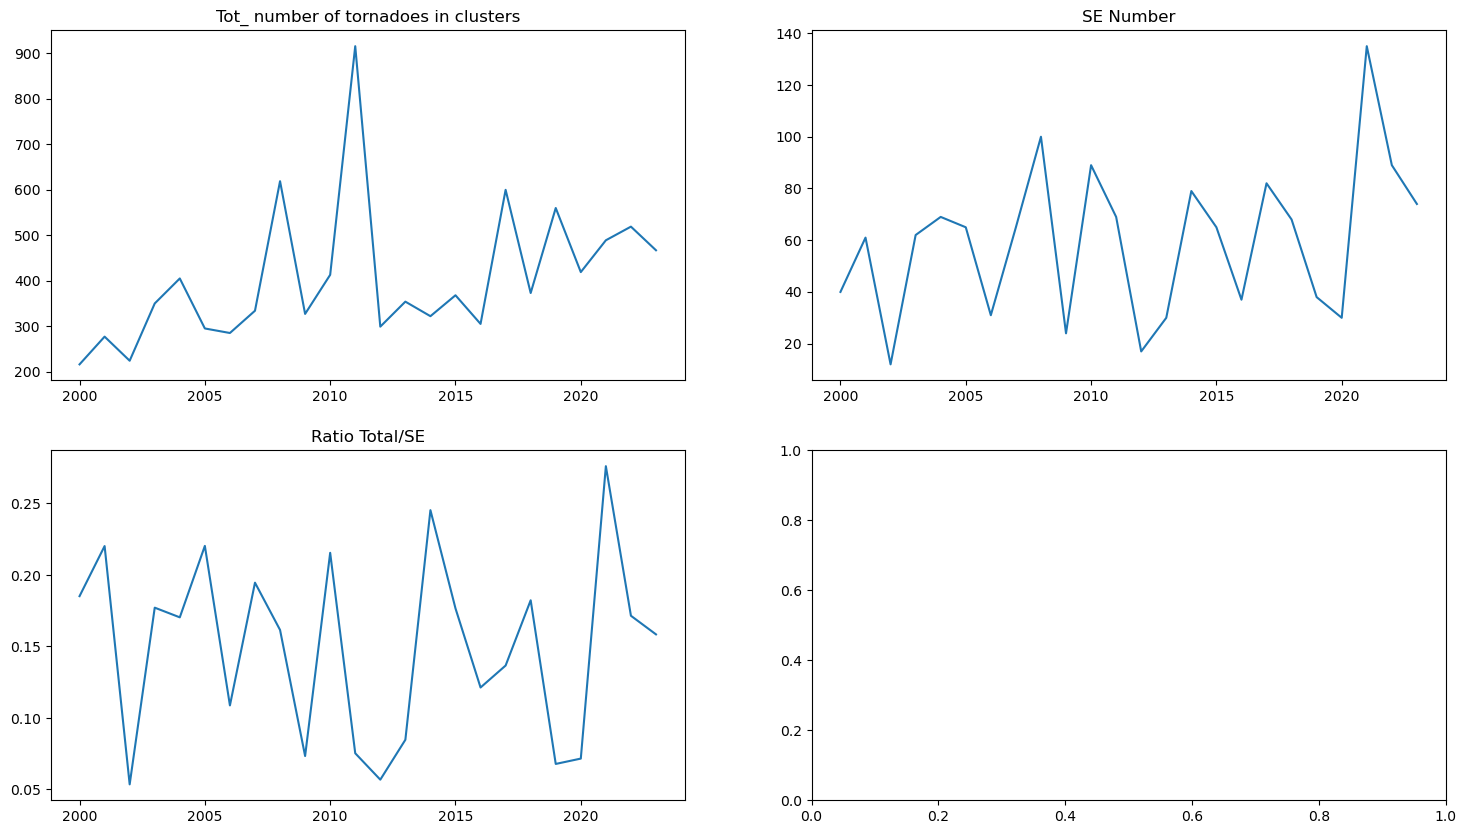

In [14]:
figsize=(10, 5)
fig, axs = plt.subplots(2, 2,figsize=(18, 10))
axs[0, 0].plot(MeanF1['Year'],MeanF1['Tot_tornadoes'])
axs[0, 0].set_title('Tot_ number of tornadoes in clusters')
axs[0, 1].plot(MeanF1['Year'],MeanF1['Num_SE'])
axs[0, 1].set_title('SE Number')
axs[1, 0].plot(MeanF1['Year'],MeanF1['Ratio'])
axs[1, 0].set_title('Ratio Total/SE')



plt.show()

In [ ]:
years=np.arange(MeanF1['Year'].min(),MeanF1['Year'].max()+1,1)
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),len(years)))

plt.figure(figsize=[16,8])   
for n,y in enumerate(years):

 
     
    plt.scatter(MeanF1.loc[MeanF1['Year']==y,'Mean_LAT'],
                MeanF1.loc[MeanF1['Year']==y,'Mean_LON'],
                c = str(colors[n]), 
                s= MeanF1.loc[MeanF1['Year']==y,'Tot_tornadoes'].values[0], 
                linewidth = 0) 
#Just to check that greens are indeed newer, reds = older     
plt.scatter(MeanF1.loc[MeanF1['Year']==2023,'Mean_LAT'],
            MeanF1.loc[MeanF1['Year']==2023,'Mean_LON'],
            c = 'b', 
            s= 90, 
            linewidth = 0)   

plt.show()

In [18]:
Total_cas_by_year=[]
Clust_cas_by_year=[]
for y in range(1950,2024):
    Total_cas_by_year.append(sum(data_file.loc[data_file['BEGIN_YEARMONTH']//100 == y]['casualties']))
    Clust_cas_by_year.append(sum(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']//100 == y]['casualties']))


In [255]:
years=np.arange(1950,2024,1)
years

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

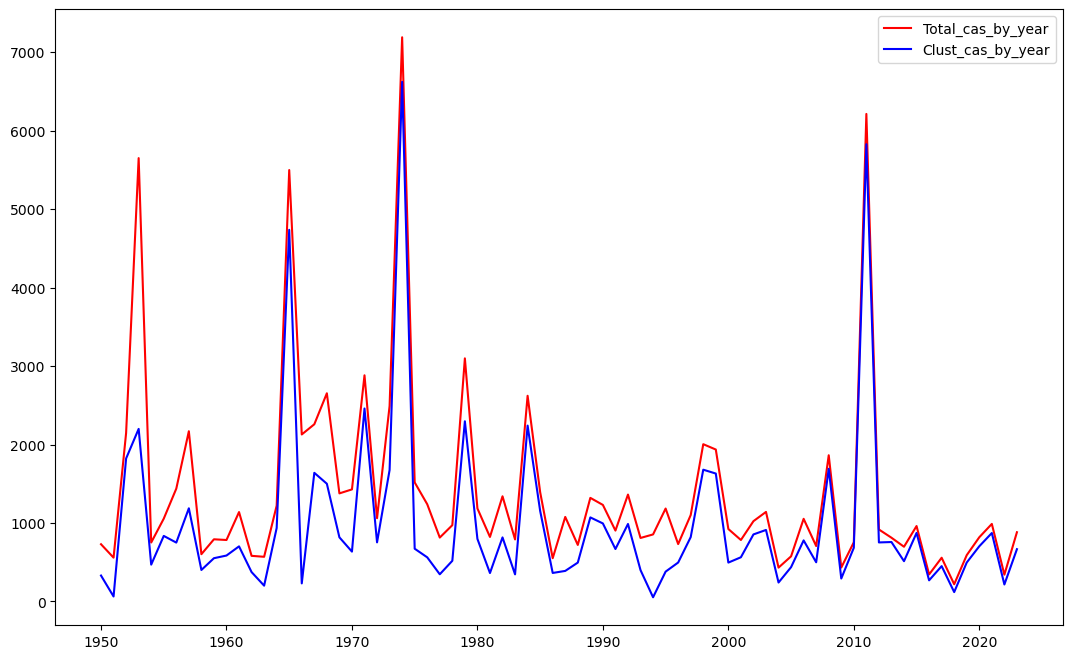

In [262]:
 
plt.figure(figsize=[13,8])
plt.plot(years, Total_cas_by_year,c='r',label='Total_cas_by_year')
plt.plot(years, Clust_cas_by_year,c='b', label='Clust_cas_by_year' )
plt.legend()
plt.show()


#plt.hist(Clust_cas_by_year)

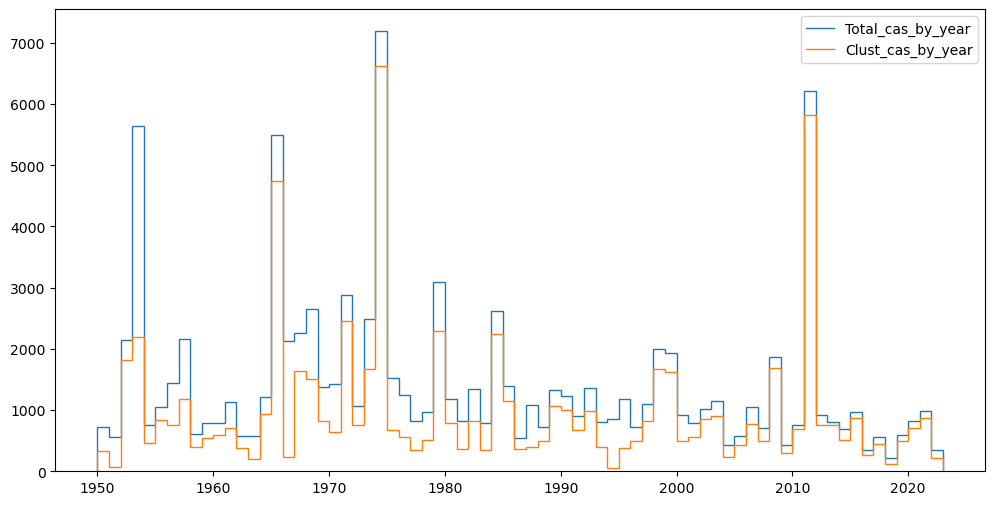

In [263]:
#Or maybe this one is better

plt.figure(figsize=[12,6])
plt.stairs(Total_cas_by_year[:-1],years,label ='Total_cas_by_year')
plt.stairs(Clust_cas_by_year[:-1],years,label='Clust_cas_by_year')
plt.legend()
plt.show()

# It lloks like starting from ~2008 almost all of the casualties are due to cluster 

In [22]:
Ratio=[ Clust_cas_by_year[i]/Total_cas_by_year[i]*100 for i in range(len(years))] 
dif_Ratio=[ (Total_cas_by_year[i]-Clust_cas_by_year[i])*100/Total_cas_by_year[i] for i in range(len(years))] 

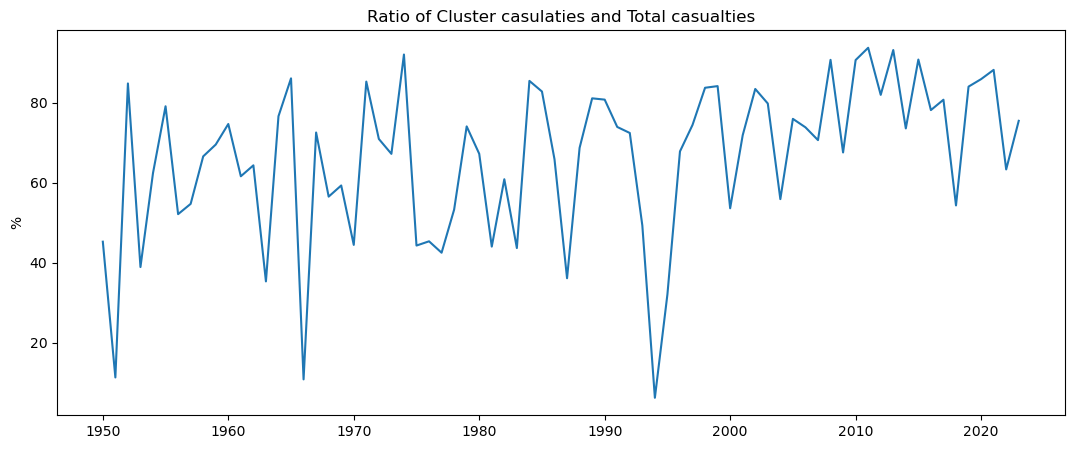

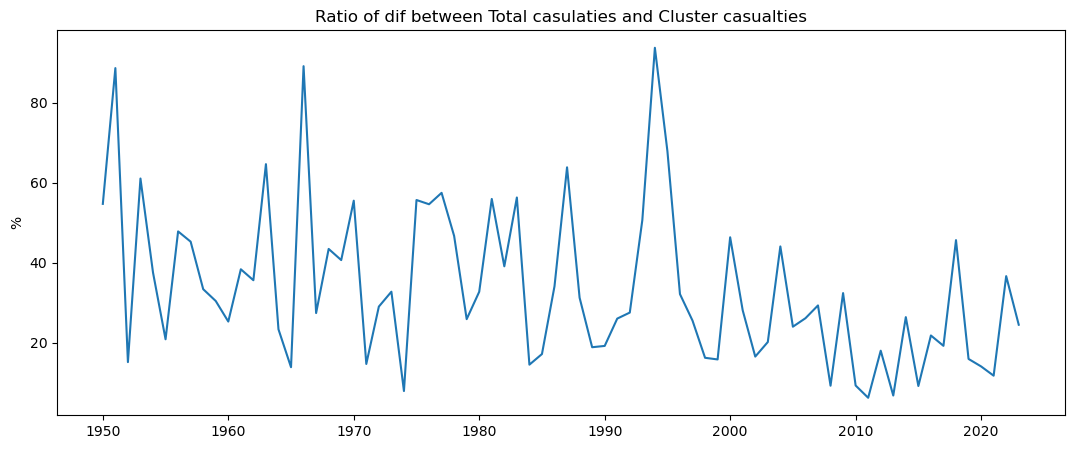

In [23]:
plt.figure(figsize=[13,5])
plt.plot(years, Ratio)
plt.title('Ratio of Cluster casulaties and Total casualties') 
plt.ylabel('%') 
plt.show()

plt.figure(figsize=[13,5])
plt.title('Ratio of dif between Total casulaties and Cluster casualties') 
plt.ylabel('%')
plt.plot(years,dif_Ratio)
plt.show()

# <center> BY DECADES <center>

In [265]:
decades=np.arange(1950,2024,10)


In [266]:
Total_cas_by_decade=[]
Clust_cas_by_decade=[]
for y in range(195000,202412,1000):
    Total_cas_by_decade.append(sum(data_file.loc[data_file['BEGIN_YEARMONTH'].between(y,y+1000)]['casualties']))
    Clust_cas_by_decade.append(sum(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH'].between(y,y+1000)]['casualties']))

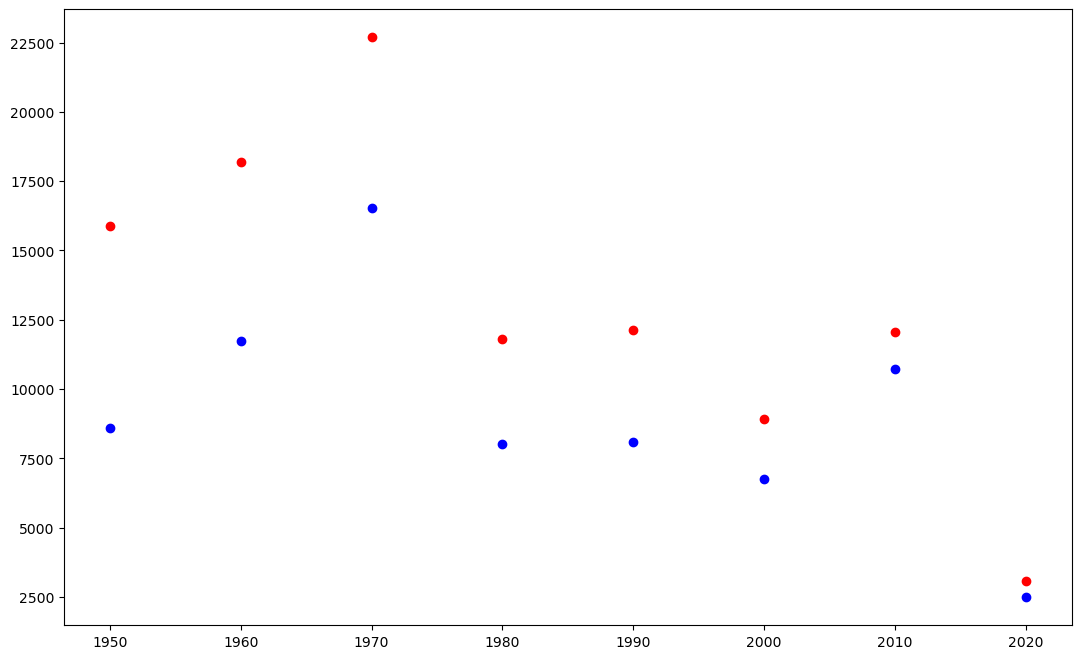

In [267]:
plt.figure(figsize=[13,8])
plt.scatter(decades, Total_cas_by_decade,c='r')
plt.scatter(decades, Clust_cas_by_decade,c='b' )
plt.show()


In [268]:
Ratio_d=[ Clust_cas_by_decade[i]/Total_cas_by_decade[i]*100 for i in range(len(decades))] 
dif_Ratio_d=[ (Total_cas_by_decade[i]-Clust_cas_by_decade[i])*100/Total_cas_by_decade[i] for i in range(len(decades))] 

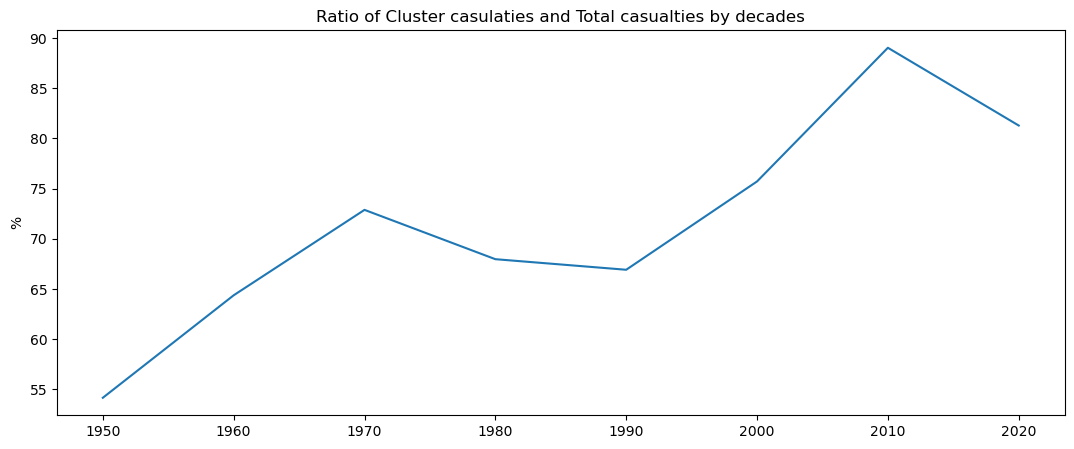

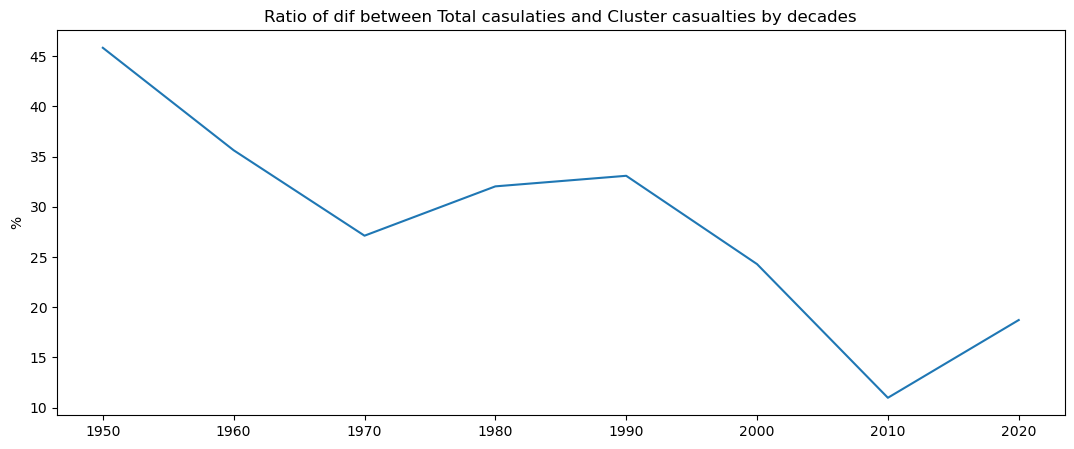

In [269]:
plt.figure(figsize=[13,5])
plt.plot(decades, Ratio_d)
plt.title('Ratio of Cluster casulaties and Total casualties by decades') 
plt.ylabel('%') 
plt.show()

plt.figure(figsize=[13,5])
plt.title('Ratio of dif between Total casulaties and Cluster casualties by decades') 
plt.ylabel('%')
plt.plot(decades,dif_Ratio_d)
plt.show()

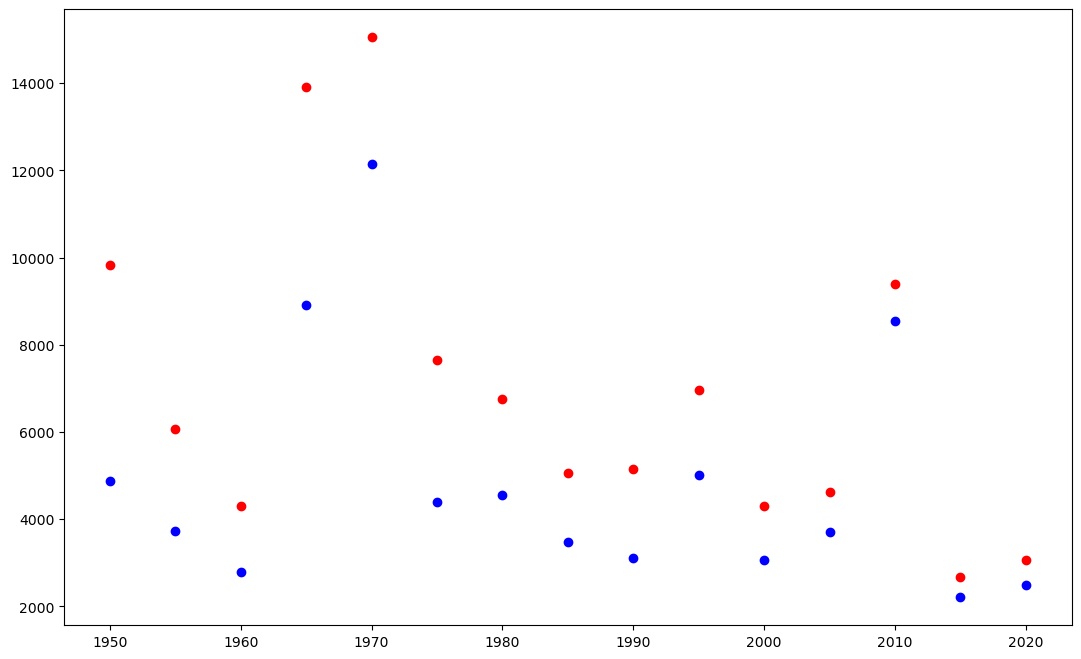

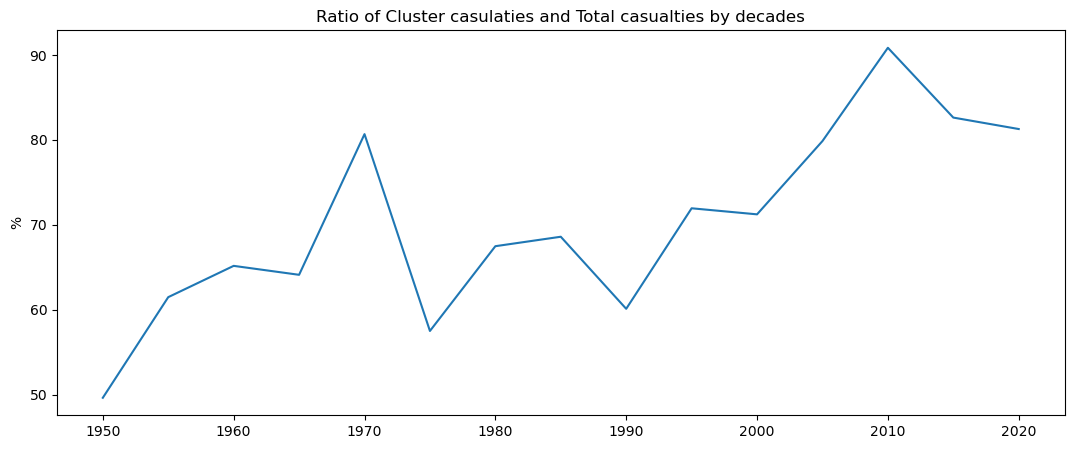

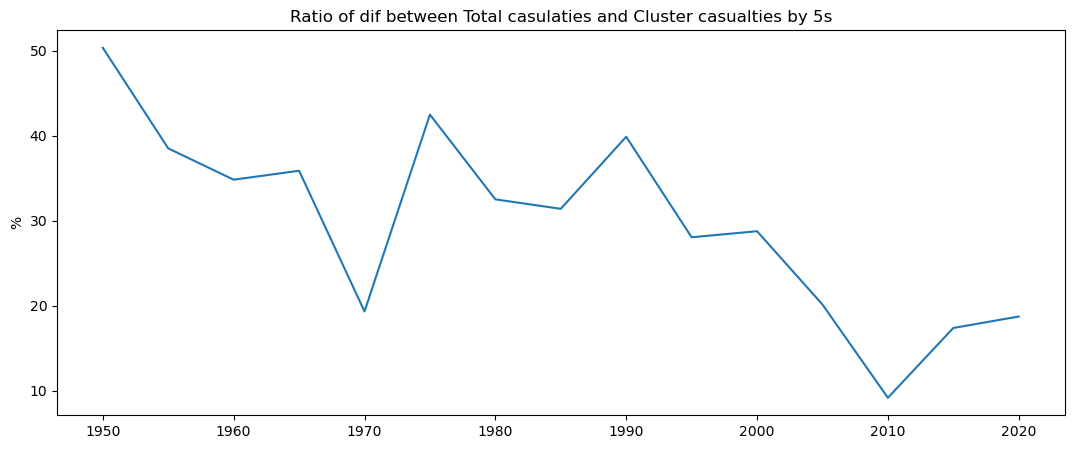

In [30]:
fives=np.arange(1950,2024,5)

Total_cas_by_5=[]
Clust_cas_by_5=[]
for y in range(195000,202412,500):
    Total_cas_by_5.append(sum(data_file.loc[data_file['BEGIN_YEARMONTH'].between(y,y+500)]['casualties']))
    Clust_cas_by_5.append(sum(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH'].between(y,y+500)]['casualties']))

plt.figure(figsize=[13,8])
plt.scatter(fives, Total_cas_by_5,c='r')
plt.scatter(fives, Clust_cas_by_5,c='b' )
plt.show()


Ratio5=[ Clust_cas_by_5[i]/Total_cas_by_5[i]*100 for i in range(len(fives))] 
dif_Ratio5=[ (Total_cas_by_5[i]-Clust_cas_by_5[i])*100/Total_cas_by_5[i] for i in range(len(fives))] 


plt.figure(figsize=[13,5])
plt.plot(fives, Ratio5)
plt.title('Ratio of Cluster casulaties and Total casualties by decades') 
plt.ylabel('%') 
plt.show()

plt.figure(figsize=[13,5])
plt.title('Ratio of dif between Total casulaties and Cluster casualties by 5s') 
plt.ylabel('%')
plt.plot(fives,dif_Ratio5)
plt.show()

In [31]:
# Mean Lon/Lat by deacades:
Mean_by_deacades_LON=[]
Mean_by_deacades_LAT=[]
for y in decades[:-1]:
    Mean_by_deacades_LON.append(mean_LatLon(Clust_F1,y,y+10)['Mean_LON'].mean())
    Mean_by_deacades_LAT.append(mean_LatLon(Clust_F1,y,y+10)['Mean_LAT'].mean())
Mean_by_deacades_LON.append(mean_LatLon(Clust_F1,2020,2024)['Mean_LON'].mean())
Mean_by_deacades_LAT.append(mean_LatLon(Clust_F1,2020,2024)['Mean_LAT'].mean())

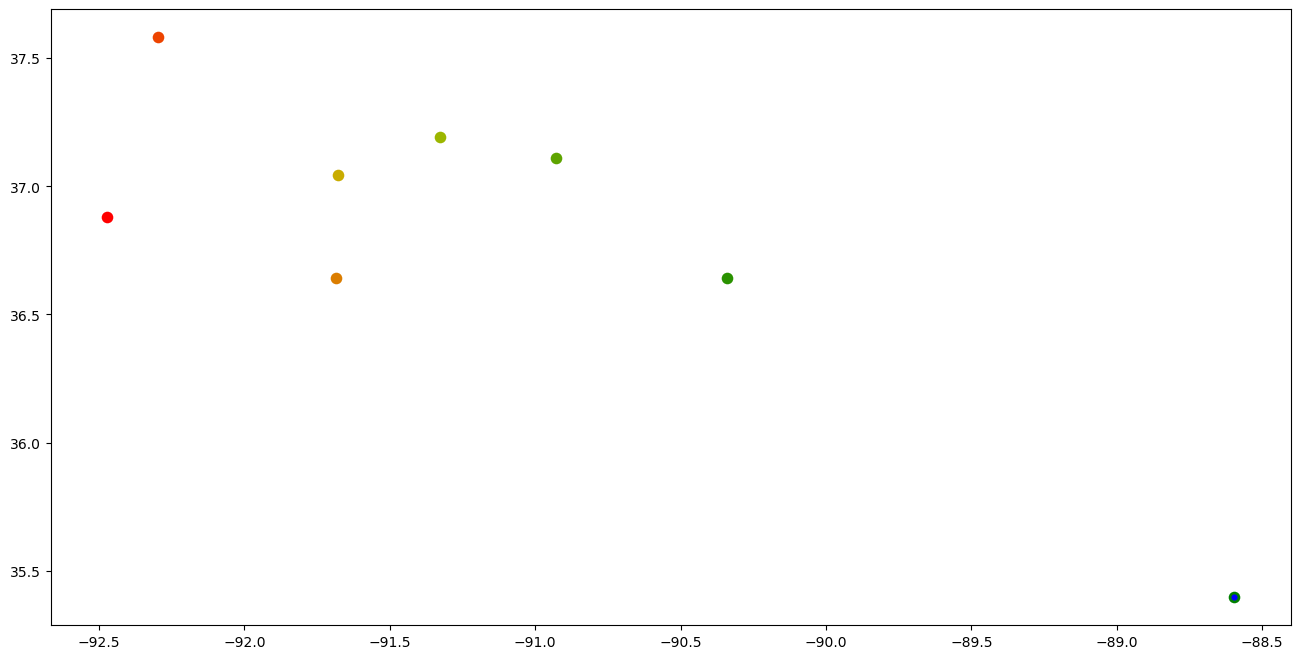

In [53]:
colors = list(red.range_to(Color("green"),len(decades)))

plt.figure(figsize=[16,8])   
for n,y in enumerate(decades):

 
     
    plt.scatter(Mean_by_deacades_LON[n],
              Mean_by_deacades_LAT[n],
                c = str(colors[n]), 
                s= 70, 
                linewidth = 0) 
    
 
plt.scatter(Mean_by_deacades_LON[7],
              Mean_by_deacades_LAT[7],
                c ='b', 
                s= 20, 
                linewidth = 0) 
plt.show()

# LOOKS BETTER THEN BY YEARS

In [36]:
'''for c in set(Clust_F1['cluster'].values):
    for b in  Clust_F1.loc[Clust_F1['cluster'] == c]:
        if ('F1' in set(b['TOR_F_SCALE'].values)) or ('EF1' in set(b['TOR_F_SCALE'].values)):
            num_ofF1+=1
        if ('F2' in set(b['TOR_F_SCALE'].values)) or ('EF2' in set(b['TOR_F_SCALE'].values)):   
            num_ofF2+=1
        if ('F3' in set(b['TOR_F_SCALE'].values)) or ('EF3' in set(b['TOR_F_SCALE'].values)):   
            num_ofF3+=1
        if ('F4' in set(b['TOR_F_SCALE'].values)) or ('EF4' in set(b['TOR_F_SCALE'].values)):   
            num_ofF4+=1
        if ('F5' in set(b['TOR_F_SCALE'].values)) or ('EF5' in set(b['TOR_F_SCALE'].values)):   
            num_ofF5+=1
            '''
             

"for c in set(Clust_F1['cluster'].values):\n    for b in  Clust_F1.loc[Clust_F1['cluster'] == c]:\n        if ('F1' in set(b['TOR_F_SCALE'].values)) or ('EF1' in set(b['TOR_F_SCALE'].values)):\n            num_ofF1+=1\n        if ('F2' in set(b['TOR_F_SCALE'].values)) or ('EF2' in set(b['TOR_F_SCALE'].values)):   \n            num_ofF2+=1\n        if ('F3' in set(b['TOR_F_SCALE'].values)) or ('EF3' in set(b['TOR_F_SCALE'].values)):   \n            num_ofF3+=1\n        if ('F4' in set(b['TOR_F_SCALE'].values)) or ('EF4' in set(b['TOR_F_SCALE'].values)):   \n            num_ofF4+=1\n        if ('F5' in set(b['TOR_F_SCALE'].values)) or ('EF5' in set(b['TOR_F_SCALE'].values)):   \n            num_ofF5+=1\n            "

In [209]:
def typestat(year, print_data=False):
    num_ofF1=0
    num_ofF2=0
    num_ofF3=0
    num_ofF4=0
    num_ofF5=0
    Num_tot=0
    for c in set(Clust_F1['cluster'].values):
        x=Counter(Clust_F1.loc[Clust_F1['cluster'].values==c,'TOR_F_SCALE'].values)
        
        if c//10000==year:
            Num_tot+=1
            num_ofF1=num_ofF1+x['F1']+x['EF1']
            num_ofF2=num_ofF2+x['F2']+x['EF2']
            num_ofF3=num_ofF3+x['F3']+x['EF3']
            num_ofF4=num_ofF4+x['F4']+x['EF4']
            num_ofF5=num_ofF5+x['F5']+x['EF5']
        
    if print_data:
       print('In', year,'Number of clusters with F1= ',num_ofF1,'Number of   clusters with F2= ',num_ofF2,'Number of   clusters with F3 = ',
          num_ofF3,'Number of   clusters  with F4= ',num_ofF4,'Number of  clusters with F5',num_ofF5,' Total clusters= ', Num_tot )
    return  [num_ofF1,num_ofF2,num_ofF3,num_ofF4,num_ofF5,Num_tot]


In [210]:
Type_data=pd.DataFrame(columns=["Year",'num_ofF1','num_ofF2','num_ofF3','num_ofF4','num_ofF5','Tot_num_of_cluster'])

for i in range(1950,2025):
     new_row=[i]+typestat(i)
     Type_data.loc[-1] = new_row # adding a row
     Type_data.index = Type_data.index + 1  # shifting index
Type_data = Type_data.sort_values(by=['Year'])

In [211]:
Type_data

,Year,num_ofF1,num_ofF2,num_ofF3,num_ofF4,num_ofF5,Tot_num_of_cluster
74,1950,8,21,20,8,0,23
73,1951,8,19,13,2,0,20
72,1952,18,26,24,21,0,34
71,1953,31,42,36,31,5,58
70,1954,39,65,38,13,0,53
...,...,...,...,...,...,...,...
4,2020,306,84,19,10,0,120
3,2021,343,111,26,9,0,120
2,2022,385,116,17,1,0,148
1,2023,306,124,35,2,0,127


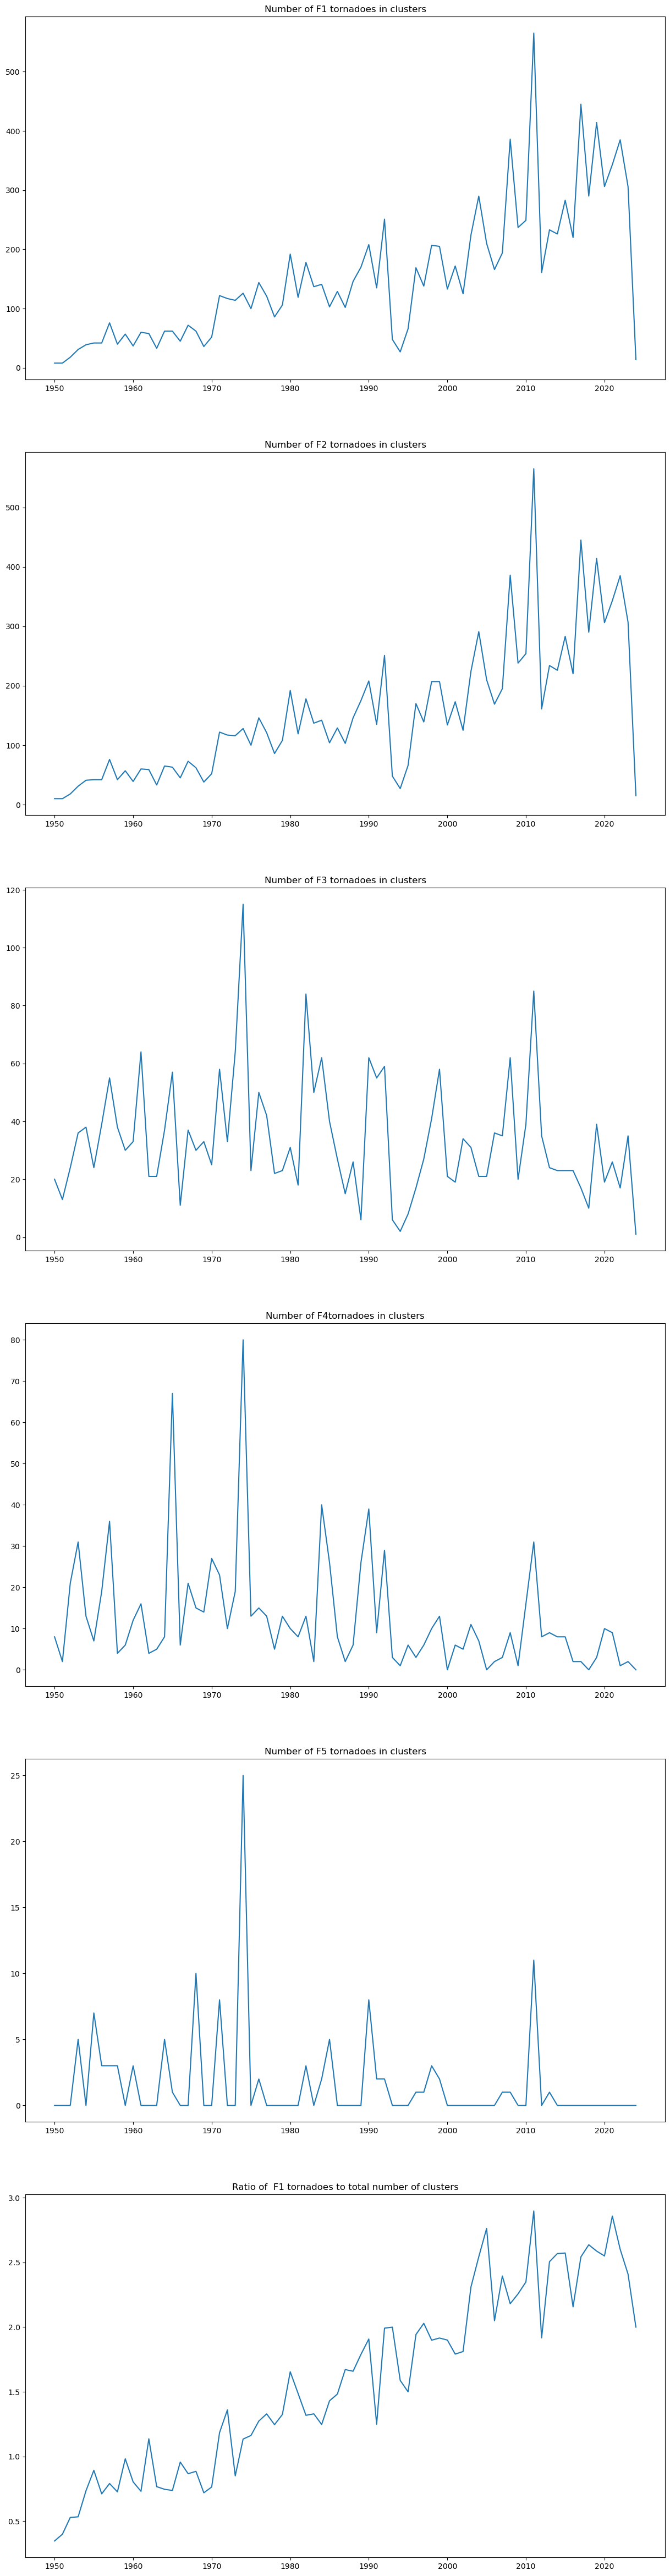

<Figure size 1600x800 with 0 Axes>

In [75]:


figure, ax = plt.subplots(6,figsize=(15, 60))

plt.figure(figsize=[16,8])
ax[0].plot(np.arange(1950,2025),Type_data['num_ofF1'])
ax[0].set_title('Number of F1 tornadoes in clusters')

ax[1].plot(np.arange(1950,2025),Type_data['num_ofF2'])
ax[1].set_title('Number of F2 tornadoes in clusters')

ax[2].plot(np.arange(1950,2025),Type_data['num_ofF3'])
ax[2].set_title('Number of F3 tornadoes in clusters')

ax[3].plot(np.arange(1950,2025),Type_data['num_ofF4'])
ax[3].set_title('Number of F4tornadoes in clusters')

ax[4].plot(np.arange(1950,2025),Type_data['num_ofF5'])
ax[4].set_title('Number of F5 tornadoes in clusters')

ax[5].plot(np.arange(1950,2025),Type_data['num_ofF1']/Type_data['Tot_num_of_cluster'])
ax[5].set_title('Ratio of  F1 tornadoes to total number of clusters')
plt.show()

In [156]:
Type_data.head()

,Year,num_ofF1,num_ofF2,num_ofF3,num_ofF4,num_ofF5,Tot_num_of_cluster
74,1950,8,21,20,8,0,23
73,1951,8,19,13,2,0,20
72,1952,18,26,24,21,0,34
71,1953,31,42,36,31,5,58
70,1954,39,65,38,13,0,53


In [170]:
#total number of tornadoes that is already calculated before in mean_stat, 
#just to check if they match
r=Type_data[Type_data.columns[1:-1]].sum(axis='columns')/Type_data['Tot_num_of_cluster']
r

74    2.478261
73    2.100000
72    2.617647
71    2.500000
70    2.924528
        ...   
4     3.491667
3     4.075000
2     3.506757
1     3.677165
0     2.857143
Length: 75, dtype: float64

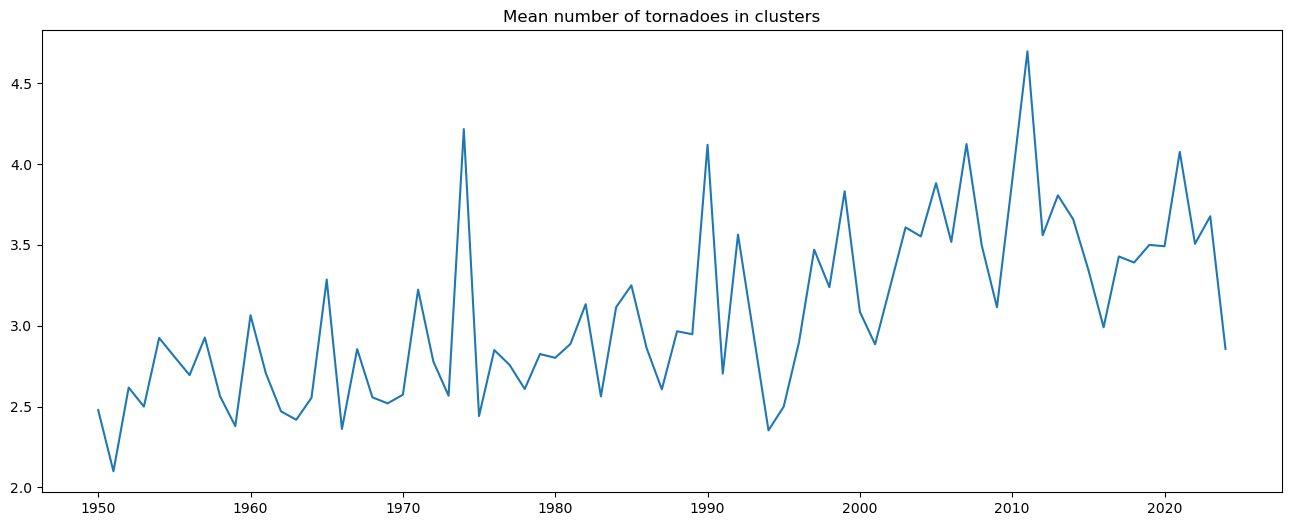

In [178]:
plt.figure(figsize=[16,6])
plt.plot(Type_data['Year'],r)
plt.title("Mean number of tornadoes in clusters")
plt.show()

In [193]:
p=Type_data.groupby(Type_data['Year']//10).mean()

In [201]:
mc=p[p.columns[1:-1]].sum(axis='columns')/p['Tot_num_of_cluster']

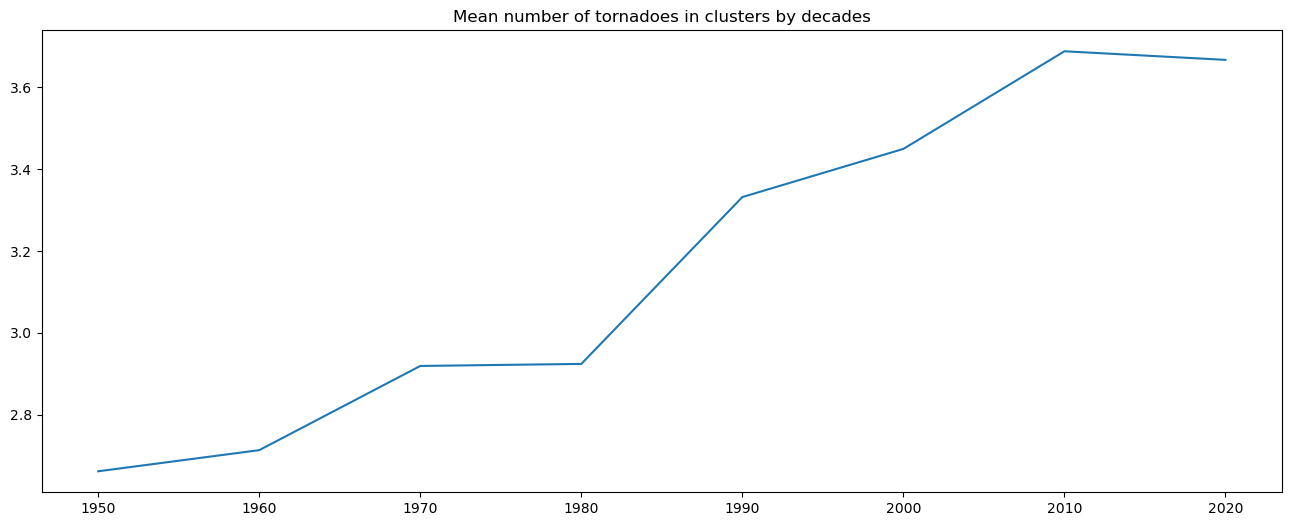

In [206]:
plt.figure(figsize=[16,6])
plt.plot(mc.index*10,mc)
plt.title("Mean number of tornadoes in clusters by decades")
plt.show()

In [207]:
p

,Year,num_ofF1,num_ofF2,num_ofF3,num_ofF4,num_ofF5,Tot_num_of_cluster
Year,,,,,,,
195,1954.5,36.1,49.3,31.7,14.7,2.1,50.3
196,1964.5,52.7,67.6,34.4,16.8,1.9,63.9
197,1974.5,108.8,95.1,45.5,21.8,3.5,94.1
198,1984.5,141.7,85.1,35.9,14.1,1.0,95.0
199,1994.5,145.4,73.5,33.5,11.9,1.9,79.9
200,2004.5,213.7,84.9,30.0,4.4,0.2,96.6
201,2014.5,308.6,100.7,31.8,8.7,1.2,122.3
202,2022.0,270.8,88.0,19.6,4.4,0.0,104.4


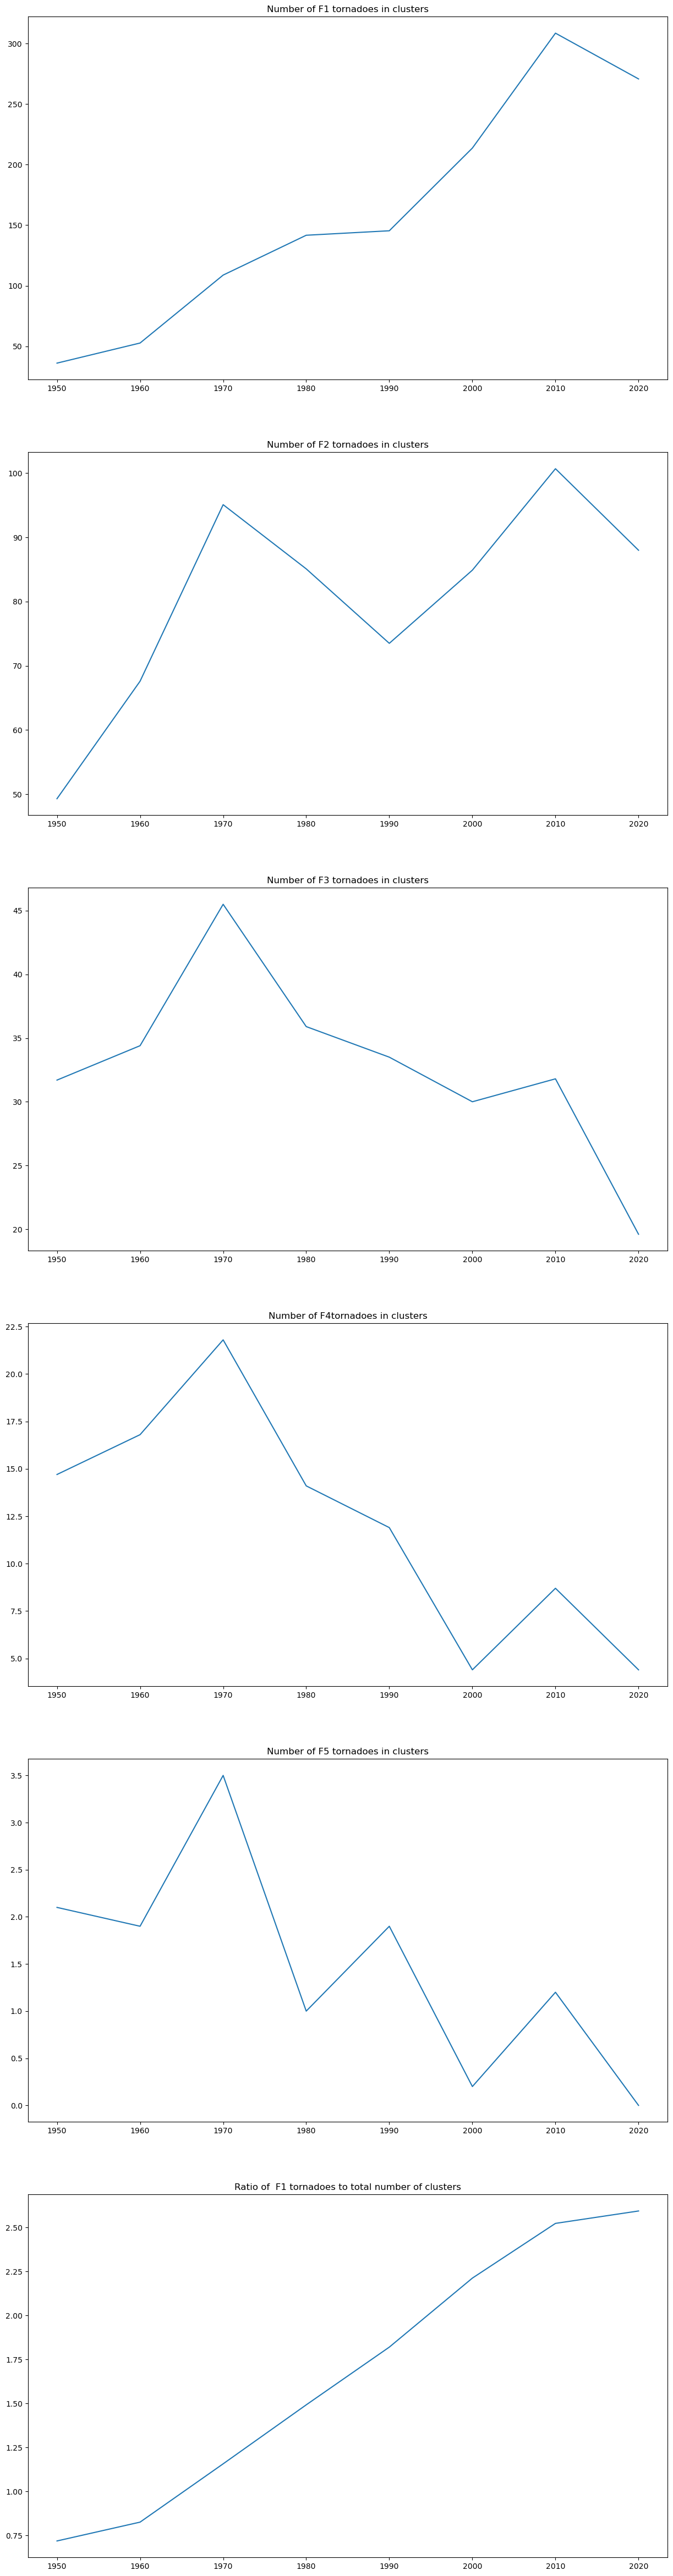

<Figure size 1600x800 with 0 Axes>

In [271]:
figure, ax = plt.subplots(6,figsize=(15, 60))

plt.figure(figsize=[16,8])
ax[0].plot(np.arange(1950,2025,10),p['num_ofF1'])
ax[0].set_title('Number of F1 tornadoes in clusters')

ax[1].plot(np.arange(1950,2025,10),p['num_ofF2'])
ax[1].set_title('Number of F2 tornadoes in clusters')

ax[2].plot(np.arange(1950,2025,10),p['num_ofF3'])
ax[2].set_title('Number of F3 tornadoes in clusters')

ax[3].plot(np.arange(1950,2025,10),p['num_ofF4'])
ax[3].set_title('Number of F4tornadoes in clusters')

ax[4].plot(np.arange(1950,2025,10),p['num_ofF5'])
ax[4].set_title('Number of F5 tornadoes in clusters')

ax[5].plot(np.arange(1950,2025,10),p['num_ofF1']/p['Tot_num_of_cluster'])
ax[5].set_title('Ratio of  F1 tornadoes to total number of clusters')
plt.show()

In [248]:
months=np.arange(1,13)
[len(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']%100==i]) for i in months]

[763, 917, 2171, 4471, 4440, 2618, 1023, 807, 702, 851, 1292, 961]

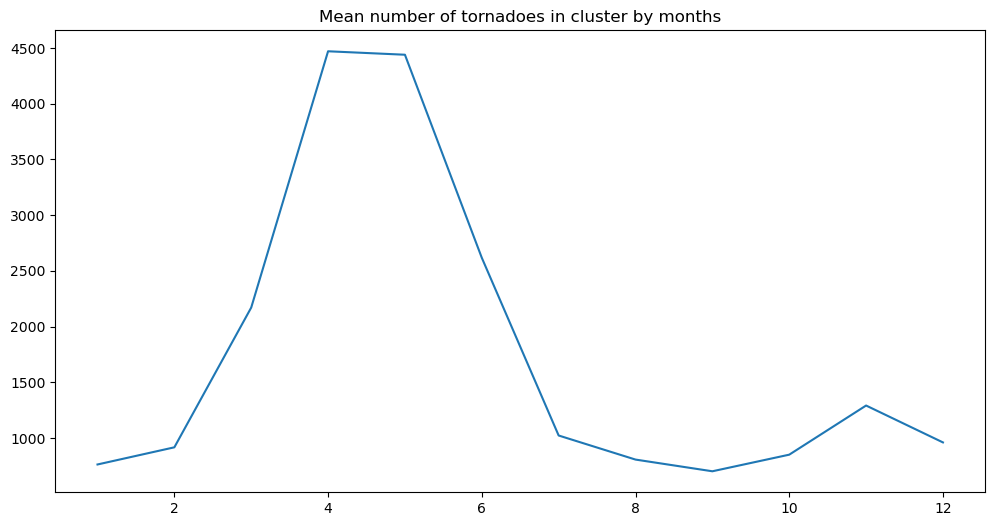

In [273]:

plt.figure(figsize=[12,6])
plt.plot(months,[len(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']%100==i]) for i in months])
plt.title('Mean number of tornadoes in cluster by months')
plt.show()

# <center>BY 5 YEARS</center> 

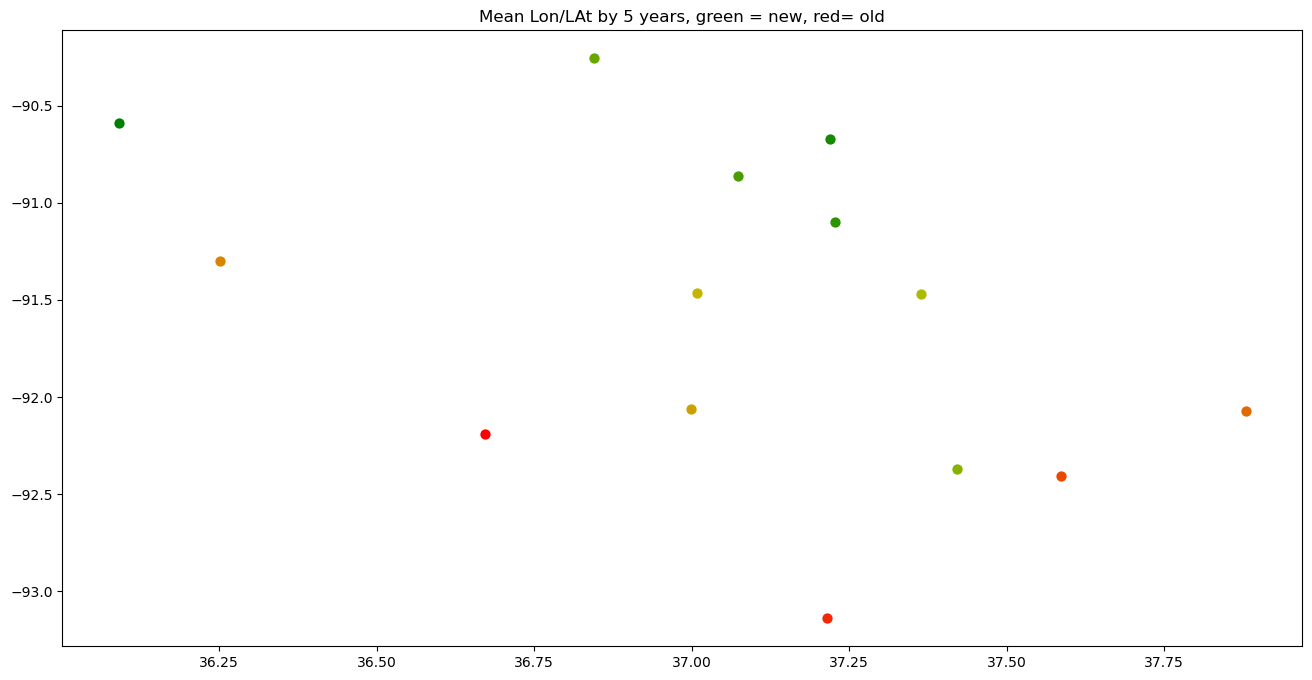

In [275]:
years5=np.arange(1950,2020,5)
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),len(years5)))

plt.figure(figsize=[16,8])   
for n,y in enumerate(years5):

 
     
    plt.scatter(mean_LatLon(Clust_F1,y,y+5)['Mean_LAT'].mean(),
                mean_LatLon(Clust_F1,y,y+5)['Mean_LON'].mean(),
                c = str(colors[n]), 
                s= 55, 
                linewidth = 0) 
    

plt.title('Mean Lon/LAt by 5 years, green = new, red= old')
plt.show()